<a href="https://colab.research.google.com/github/Bennath-coder/Bennath-coder/blob/main/S6_015P_a%CC%80_016P_Exercices_NLP_avec_Keras_versionNPz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans cet exercice, nous allons reprendre le modèle de NLP que nous avons construit dans la partie théorique (analyse de sentiment sur les données IMDB) et nous allons essayer de l'évaluer et de l'améliorer.

Vous pouvez exécuter les cellules suivantes :

In [3]:
!pip install --upgrade pip
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver do

In [4]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers, models

In [5]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  33.1M      0  0:00:02  0:00:02 --:--:-- 33.1M


In [6]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

import string
import re

def cleaning(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

vectorize_layer = keras.layers.TextVectorization(
    standardize=cleaning, # On passe notre fonction de nettoyage
    max_tokens=20_000, # Limite le vocabulaire aux 20_000 mots les plus utilisés
    output_mode="int", # Les sorties sont des séquences de mots encodées comme des entiers
    output_sequence_length=500, # Taille max des critiques
)

# On entraine notre couche de vectorisation sur nos données spécifiques :
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

# On va utiliser notre 'vectorize_layer' pour transformer nos données
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Enfin, on vectorise nos données
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Exercice 1 : Créer un réseau de neurones pour du NLP

1.1. Créer un modèle possédant les couches suivantes :    
- Une couche d'input (avec une `shape=(None,)` car les critiques peuvent faire différentes longueurs et un `dtype="int64"`)
- Une couche d'embedding transformant les critiques de taille 20 000 en une représentation sémantique de taille 16
- Une couche de Convolution 1D avec 16 filtres et un `kernel_size=5`
- Une couche de `GlobalMaxPooling1D`
- Une couche dense contenant 16 neurones
- Une couche de sortie pour de la classification binaire (1 neurone et une fonction d'activation sigmoïd)

In [7]:
# Création du modèle
model = keras.Sequential(
  [
# Couche d'input
keras.layers.Input(shape=(None,), dtype="int64"),

# Couche d'Embedding = créé une représentation sémantique du vocabulaire
keras.layers.Embedding(20_000, 16),

# Couche de Convolution 1D = traite les données séquentielles
keras.layers.Conv1D(16, 5, activation='relu', strides=3),

# Couche de GlobalMaxPooling1D = ramène les données sur 1 dimension pour les traiter ensuite avec une couche dense
keras.layers.GlobalMaxPooling1D(),

# Couche dense avec 16 neurones
keras.layers.Dense(16, activation='relu'),

# Couche de sortie pour la classification binaire
keras.layers.Dense(1, activation='sigmoid')
]
)

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 16)            │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 16)            │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321,585 (1.23 MB)

 Trainable params: 321,585 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

1.2. Compiler le modèle en utilisant :    
- La binary crossentropy comme fonction coût
- Un optimizer Adam
- L'accuracy comme métrique d'évaluation

In [9]:
# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #optimizer='adam' = rmsprop


1.3. Entraîner le modèle durant 10 epochs. Sauvegarder l'historique d'entraînement dans une variable history.

In [10]:
# Entraînement du modèle avec des données
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6139 - loss: 0.6442 - val_accuracy: 0.8284 - val_loss: 0.3989
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8550 - loss: 0.3382 - val_accuracy: 0.8542 - val_loss: 0.3473
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9254 - loss: 0.1922 - val_accuracy: 0.8498 - val_loss: 0.3713
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9724 - loss: 0.0897 - val_accuracy: 0.8512 - val_loss: 0.4376
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9924 - loss: 0.0319 - val_accuracy: 0.8550 - val_loss: 0.4901
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9994 - loss: 0.0085 - val_accuracy: 0.8588 - val_loss: 0.5016
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.8598 - val_loss: 0.5307
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 1.0000 - loss: 9.2678e-04 - v

1.4 Evaluer le modèle avec la méthode `evaluate`

In [11]:
model.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8625 - loss: 0.6310


[0.6239294409751892, 0.8643199801445007]

1.5. Afficher les courbes d'apprentissagess. Que pouvez vous en déduire ?

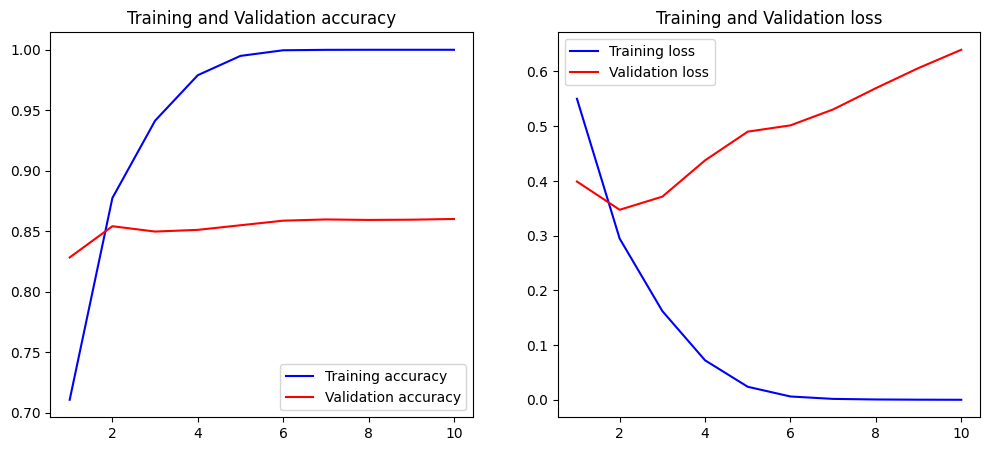

In [19]:
import matplotlib.pyplot as plt


def plot_history(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(accuracy) + 1) # Define x within the function scope

  # Tracer la courbe de la perte pendant l'entraînement
  plt.figure(figsize=(12, 5))

  # Accuracy
  plt.subplot(1, 2, 1)
  plt.plot(x, accuracy, 'b', label='Training accuracy') # x is now accessible
  plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.legend()

  # Loss
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss') # x is now accessible
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show() # Show plot within the function

# Call the function to plot the history
plot_history(history) # Assuming 'history' is defined and contains training history

Le modèle est en overfitting dès la 3è epoch. Gros écart entre la loss du jeu de validation et d'entraînement. La courbe de la loss augmente ce qui démontre un overfitting très important, on va donc le prendre en considération dans un second temps pour améliorer les performances de mon modèle.

Explication des courbes :
Courbe de la perte (loss) :

Cette courbe montre comment la fonction de perte (ici binary_crossentropy pour la classification binaire) évolue au cours des époques.
Si la courbe de la perte diminue de manière régulière, cela signifie que le modèle améliore sa capacité à minimiser l'erreur sur les données d'entraînement.
Si la perte augmente ou se stabilise après quelques époques, cela peut indiquer un overfitting ou que le modèle a atteint un minimum local dans l'optimisation.
Courbe de la précision (accuracy) :

Cette courbe montre l'évolution de la précision (le pourcentage de prédictions correctes) sur les données d'entraînement.
Si la précision augmente, cela signifie que le modèle apprend à mieux classer les critiques. Une bonne précision indique que le modèle se généralise bien sur les données d'entraînement.
Si la précision se stabilise ou diminue après un certain nombre d'époques, cela peut aussi signaler un surapprentissage (overfitting) où le modèle commence à mémoriser les données d'entraînement plutôt que d'apprendre à généraliser.
Ce que vous pouvez en déduire :
Si la perte diminue de manière constante et que la précision augmente, cela signifie que l'entraînement progresse bien et que le modèle est en train de mieux comprendre les relations dans les données.

Si la courbe de perte se stabilise après un certain nombre d'époques, cela peut signifier que le modèle a convergé vers une solution optimale pour les données d'entraînement.

Si la précision atteint un plateau, cela pourrait indiquer que le modèle a atteint un point où il est difficile de progresser davantage sur les données d'entraînement, ou qu'il est déjà assez performant.

Si la perte commence à augmenter après quelques époques, cela peut être un signe de surapprentissage. Dans ce cas, il pourrait être utile d'ajouter des techniques de régularisation, comme le dropout, ou de réduire la complexité du modèle pour éviter qu'il n'apprenne trop bien les détails spécifiques des données d'entraînement.

Si la précision stagne ou diminue alors que la perte continue de diminuer, cela pourrait indiquer un problème de biais dans les données ou dans l'optimisation, ce qui mérite d'être investigué davantage.

Si tu observes l'une de ces situations, tu pourrais ajuster ton modèle ou tes hyperparamètres (comme le taux d'apprentissage ou la taille du batch) pour améliorer l'entraînement.

1.6. Reprenez l'architecture de votre modèle et rajoutez une couche de `Dropout` après votre couche d'embedding ainsi qu'après votre couche dense contenant 16 neurones.

Cette couche doit appliquer du dropout sur 50% des sorties, de cette manière : `Dropout(0.5)`

Ré-entraînez le modèle (n'oubliez pas de relancer `model.compile()`) Que constatez-vous ?

In [20]:
# Création du modèle
model = keras.Sequential(
  [
# Couche d'input
keras.layers.Input(shape=(None,), dtype="int64"),

# Couche d'Embedding = cré une représentation sémantique du vocabulaire
keras.layers.Embedding(20_000, 16),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de Convolution 1D = traite les données séquentielles
keras.layers.Conv1D(16, 5, activation='relu'),

# Couche de GlobalMaxPooling1D = ramène les données sur 1 dimension pour les traiter ensuite sur une couche dense
keras.layers.GlobalMaxPooling1D(),

# Couche dense avec 16 neurones
keras.layers.Dense(16, activation='relu'),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de sortie pour la classification binaire
keras.layers.Dense(1, activation='sigmoid')
]
)

In [21]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5495 - loss: 0.6761 - val_accuracy: 0.7426 - val_loss: 0.5341
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7658 - loss: 0.5130 - val_accuracy: 0.8086 - val_loss: 0.4248
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8304 - loss: 0.4177 - val_accuracy: 0.8286 - val_loss: 0.3881
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8591 - loss: 0.3644 - val_accuracy: 0.8384 - val_loss: 0.3708
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8826 - loss: 0.3158 - val_accuracy: 0.8332 - val_loss: 0.3794
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8966 - loss: 0.2884 - val_accuracy: 0.8578 - val_loss: 0.3428
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.9078 - loss: 0.2611 - val_accuracy: 0.8550 - val_loss: 0.3516
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9146 - loss: 0.2356 - 

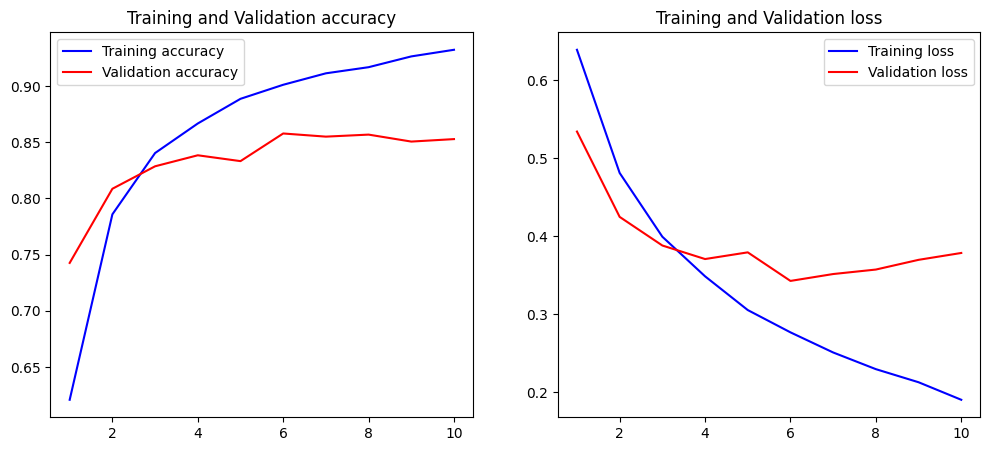

In [22]:
# Entraînement du modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Affichage de l'historique d'entraînement
plot_history(history)

On peut voir que c'est beaucoup mieux que le modèle précédent, avec des courbes qui overfittent un petit peu, notamment au niveau de la loss après la 5è epoch qu'on va commencer à diverger entre le training et la validation mais on a un contraste beaucoup moins fort que sur l'autre modèle (avec des écarts assez grands) et ici nous sommes sur quelque chose d'un peu plus mesuré. De la même manière on voit que ça commence à overfitter sur l'accuracy et une augmentation que se fait un peu plus en douceur jusqu'à atteindre un plateau.
Ici on est apriori sur un meilleur modèle, un modèle qui va mieux se généraliser.

**Modèle plus simple**

Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5323 - loss: 0.6812 - val_accuracy: 0.7610 - val_loss: 0.5128
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.7764 - loss: 0.4933 - val_accuracy: 0.8136 - val_loss: 0.4188
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8424 - loss: 0.3945 - val_accuracy: 0.8404 - val_loss: 0.3745
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8728 - loss: 0.3392 - val_accuracy: 0.8486 - val_loss: 0.3646
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.8937 - loss: 0.2903 - val_accuracy: 0.8498 - val_loss: 0.3665
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9096 - loss: 0.2585 - val_accuracy: 0.8412 - val_loss: 0.3912
Epoch 7/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9164 - loss: 0.2399 - val_accuracy: 0.8520 - val_loss: 0.3679


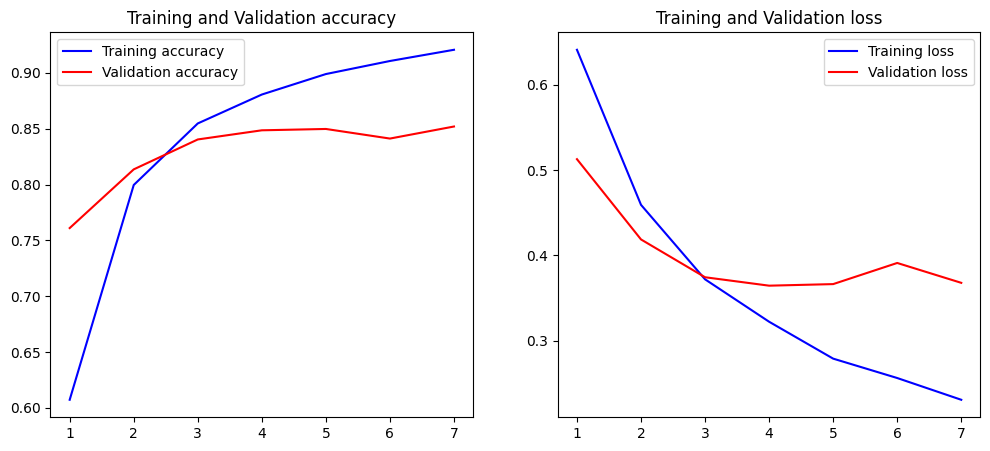

In [26]:
# Création du modèle
model = keras.Sequential(
  [
# Couche d'input
keras.layers.Input(shape=(None,), dtype="int64"),

# Couche d'Embedding = cré une représentation sémantique du vocabulaire
keras.layers.Embedding(20_000, 16),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de Convolution 1D = traite les données séquentielles
keras.layers.Conv1D(16, 7, activation='relu'),

# Couche de GlobalMaxPooling1D = ramène les données sur 1 dimension pour les traiter ensuite sur une couche dense
keras.layers.GlobalMaxPooling1D(),

# Couche dense avec 16 neurones
keras.layers.Dense(16, activation='relu'),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de sortie pour la classification binaire
keras.layers.Dense(1, activation='sigmoid')
]
)

model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Entraînement du modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=7)
plot_history(history)

**Ajout de complexité**

In [27]:
# Création du modèle
model = keras.Sequential(
  [
# Couche d'input
keras.layers.Input(shape=(None,), dtype="int64"),

# Couche d'Embedding = cré une représentation sémantique du vocabulaire
keras.layers.Embedding(20_000, 32),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de Convolution 1D = traite les données séquentielles
keras.layers.Conv1D(32, 5, activation='relu'),

# Couche de GlobalMaxPooling1D = ramène les données sur 1 dimension pour les traiter ensuite sur une couche dense
keras.layers.GlobalMaxPooling1D(),

# Couche dense avec 16 neurones
keras.layers.Dense(16, activation='relu'),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de sortie pour la classification binaire
keras.layers.Dense(1, activation='sigmoid')
]
)

model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Entraînement du modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5718 - loss: 0.6602 - val_accuracy: 0.7812 - val_loss: 0.4675
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7900 - loss: 0.4625 - val_accuracy: 0.8444 - val_loss: 0.3643
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.8568 - loss: 0.3535 - val_accuracy: 0.8666 - val_loss: 0.3205
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8936 - loss: 0.2974 - val_accuracy: 0.8706 - val_loss: 0.3019
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9103 - loss: 0.2524 - val_accuracy: 0.8736 - val_loss: 0.3049


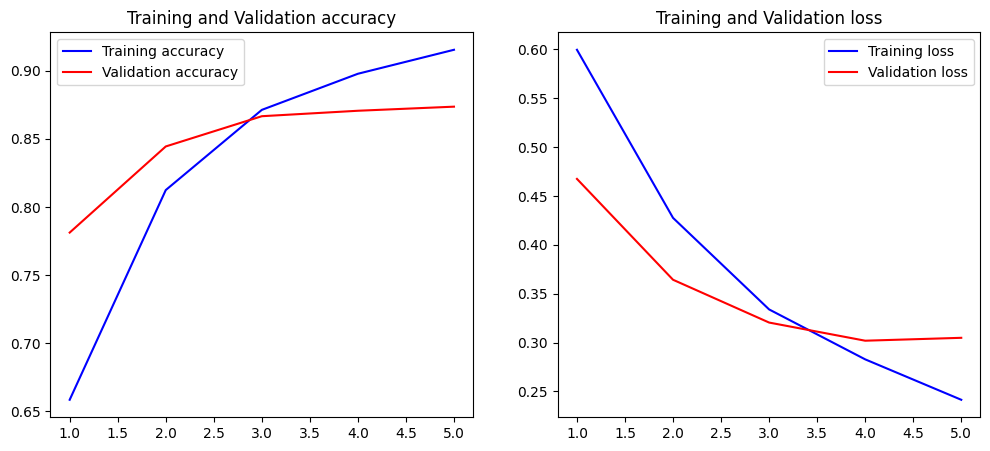

In [28]:
plot_history(history)

In [29]:
model.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8760 - loss: 0.3049


[0.3006722331047058, 0.8784800171852112]

**Essai d'une autre architecture**

In [30]:
# Création du modèle
model = keras.Sequential(
  [
# Couche d'input
keras.layers.Input(shape=(None,), dtype="int64"),

# Couche d'Embedding = cré une représentation sémantique du vocabulaire
keras.layers.Embedding(20_000, 16),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de Convolution LSTM = traite les données séquentielles
keras.layers.LSTM(8, activation='tanh'),

# Couche dense avec 8 neurones
keras.layers.Dense(8, activation='relu'),

# Couche dropout
keras.layers.Dropout(0.5),

# Couche de sortie pour la classification binaire
keras.layers.Dense(1, activation='sigmoid')
]
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, None, 16)            │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, None, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,881 (1.22 MB)

 Trainable params: 320,881 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Entraînement du modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 188ms/step - accuracy: 0.5013 - loss: 0.6931 - val_accuracy: 0.5054 - val_loss: 0.6926
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 171ms/step - accuracy: 0.5139 - loss: 0.6927 - val_accuracy: 0.5056 - val_loss: 0.6922
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 169ms/step - accuracy: 0.5155 - loss: 0.6890 - val_accuracy: 0.5092 - val_loss: 0.6896
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 177ms/step - accuracy: 0.5253 - loss: 0.6784 - val_accuracy: 0.5096 - val_loss: 0.6917
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 137s 170ms/step - accuracy: 0.5268 - loss: 0.6683 - val_accuracy: 0.5098 - val_loss: 0.7015


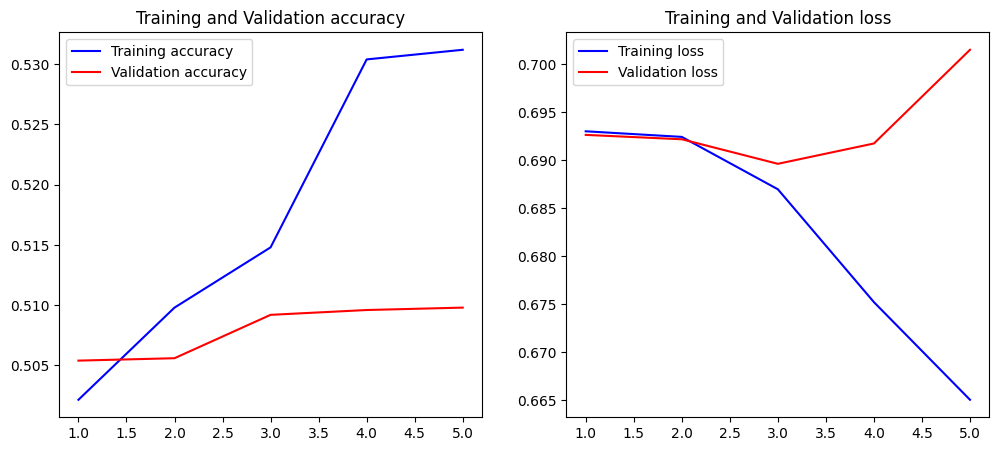

In [32]:
plot_history(history)

## Exercice 2 : Identifier l'architecture du réseau

2.1. Combien y'a t-il de paramètres dans le réseau précédent ?

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 16)            │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 16)            │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 964,757 (3.68 MB)

 Trainable params: 321,585 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 643,172 (2.45 MB)

Le modèle contient **964 757 paramètres au total**.

2.2. Parmi eux, combien sont des paramètres entraînables ?

Le modèle contient **321,585 paramètres entrainables**.





Pour calculer le nombre de paramètres dans le réseau de neurones que tu as défini, il faut analyser chaque couche du modèle et compter le nombre de poids et de biais associés à chaque couche.

Voici comment le nombre de paramètres est calculé pour chaque couche :

Couche d'Embedding (Embedding):

La couche d'Embedding a un poids pour chaque indice dans le vocabulaire (20 000 mots), et chaque mot est représenté par un vecteur de dimension 16.
Nombre de paramètres = input_dim * output_dim = ( 20000 \times 16 = 320,000 ) paramètres.
Il n'y a pas de biais dans la couche d'Embedding.
Couche de Convolution 1D (Conv1D):

La couche de convolution 1D a des filtres (kernels) qui appliquent une transformation sur les séquences.
Nombre de filtres = 16 et taille du noyau (kernel) = 5.
Chaque filtre a un poids pour chaque dimension d'entrée (ici, 16 dimensions par vecteur d'embedding), donc le nombre de poids pour chaque filtre est ( 5 \times 16 = 80 ).
Nombre total de poids = ( 80 \times 16 = 1,280 ).
Il y a aussi un biais par filtre, donc nombre de biais = 16.
Nombre total de paramètres dans cette couche = ( 1,280 + 16 = 1,296 ).
Couche de GlobalMaxPooling1D (GlobalMaxPooling1D):

Cette couche n'a pas de paramètres, car elle ne fait qu'agréger les activations de la couche précédente (en prenant le maximum de chaque filtre).
Nombre de paramètres = 0.
Couche Dense avec 16 neurones (Dense):

La couche dense prend comme entrée le nombre de filtres de la couche précédente après le pooling (16 filtres) et a 16 neurones.
Nombre de poids = ( 16 \times 16 = 256 ).
Il y a aussi un biais pour chaque neurone, donc nombre de biais = 16.
Nombre total de paramètres dans cette couche = ( 256 + 16 = 272 ).
Couche de Dropout (Dropout):

La couche Dropout n'a pas de paramètres à proprement parler, elle n'est qu'une opération de régularisation.
Nombre de paramètres = 0.
Couche de sortie Dense (Dense):

Cette couche de sortie est une couche dense avec 1 neurone (pour la classification binaire) et prend comme entrée les 16 neurones de la couche précédente.
Nombre de poids = ( 16 \times 1 = 16 ).
Il y a aussi un biais pour ce neurone, donc nombre de biais = 1.
Nombre total de paramètres dans cette couche = ( 16 + 1 = 17 ).
Total des paramètres :
En additionnant les paramètres de toutes les couches :

Couche d'Embedding : 320,000
Couche de Convolution 1D : 1,296
Couche de GlobalMaxPooling1D : 0
Couche Dense (16 neurones) : 272
Couche Dropout : 0
Couche de sortie Dense : 17
Total des paramètres = 320,000 + 1,296 + 0 + 272 + 0 + 17 = 321,585 paramètres
